In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import itertools
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
import tqdm.notebook as tqdm

In [ ]:
try: 
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version. 
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details 
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric 
    import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 5.4 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 5.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.3 MB 5.4 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 747 kB 5.2 MB/s 
     |████████████████████████████████| 325 kB 5.4 MB/s 
     |████████████████████████████████| 407 kB 39.1 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=1aa78b0bbbdebd0cb21db90d85c2ada3252aa36aa41106f842e568beed20e2cf
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built to

In [ ]:
from torch_geometric.data import Data

In [ ]:
from torch.utils.data import Dataset

In [ ]:
from torch_geometric.nn import GCNConv

In [ ]:
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [ ]:
!pip install git+https://github.com/fiuneuro/brainconn.git

  Cloning https://github.com/fiuneuro/brainconn.git to /tmp/pip-req-build-kk2xxsul
  Running command git clone -q https://github.com/fiuneuro/brainconn.git /tmp/pip-req-build-kk2xxsul
  Created wheel for brainconn: filename=brainconn-0.0.1-py3-none-any.whl size=108873 sha256=3c7c98598699bc83bb8b21af6301145e12ae94c1d6aa531ea0e61071d53982d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-szj46ufu/wheels/5f/14/55/706218d76ed62fb592168a545321b31b2bd7e4e466a5d849d9
Successfully built brainconn


In [ ]:
import random

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import brainconn

Failed to import duecredit due to No module named 'duecredit'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = 'drive/My Drive/INF554/'

In [ ]:
df_train = pd.read_csv(DATA_DIR + 'inf554-2021/train.csv', dtype={'author': np.int64, 'hindex': np.float32})
n_train = df_train.shape[0]

In [ ]:
df_test = pd.read_csv(DATA_DIR + 'inf554-2021/test.csv', dtype={'author': np.int64})
n_test = df_test.shape[0]

In [ ]:
df_test.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
G = nx.read_edgelist(DATA_DIR + 'inf554-2021/coauthorship.edgelist', delimiter=' ', nodetype=int)
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges() 
print('Number of nodes:', n_nodes)
print('Number of edges:', n_edges)

Number of nodes: 217801
Number of edges: 1718164


In [ ]:
core_number = nx.core_number(G)

In [ ]:
page_rank = nx.pagerank(G, alpha=0.9)

In [ ]:
average_neighbor_deg = nx.average_neighbor_degree(G)

In [ ]:
onion_layers = nx.core.onion_layers(G)

In [ ]:
diversity_coeff = dict()

for node in list(G.nodes):
  degree = G.degree(node)
  diversity_coeff[node] = 0.

  for neighbor in G.neighbors(node):
    p = 1. / G.degree(neighbor)
    diversity_coeff[node] += p*np.log(p)
  
  if np.log(degree) != 0:
    diversity_coeff[node] /= np.log(degree)

In [ ]:
#communities = nx.algorithms.community.greedy_modularity_communities(G)

In [ ]:
#communities

In [ ]:
! pip install python-louvain 

In [ ]:
import community.community_louvain as community_louvain

partion = community_louvain.best_partition(G)

In [ ]:
num_com = len(list(set([i for i in partion.values()])))

In [ ]:
num_com

166

In [ ]:
from collections import Counter

com_size = Counter(partion.values())

In [ ]:
inv_partion = {}

for k, v in partion.items():
    inv_partion[v] = inv_partion.get(v, []) + [k]

In [ ]:
community_centrality = dict()

for node in tqdm.tqdm(list(G.nodes)):
  neighbors = [n for n in G.neighbors(node)]
  community_centrality[node] = 0.

  for i in range(num_com):
    com_nodes = inv_partion[i]
    n_c = len(com_nodes)
    d_c = len(list(set(com_nodes) & set(neighbors)))
    community_centrality[node] += d_c*n_c / n_nodes

  0%|          | 0/217801 [00:00<?, ?it/s]

In [ ]:
X_train = np.zeros((n_train, 7))
y_train = np.zeros(n_train)
for i,row in df_train.iterrows():
    node = row['author']
    X_train[i,0] = G.degree(node)
    X_train[i,1] = core_number[node]
    X_train[i,2] = page_rank[node]
    X_train[i,3] = average_neighbor_deg[node]
    X_train[i,4] = onion_layers[node]
    X_train[i,5] = diversity_coeff[node]
    X_train[i,6] = community_centrality[node]
    y_train[i] = row['hindex']

In [ ]:
X_test = np.zeros((n_test, 7))
for i,row in df_test.iterrows():
    node = row['author']
    X_test[i,0] = G.degree(node)
    X_test[i,1] = core_number[node]
    X_test[i,2] = page_rank[node]
    X_test[i,3] = average_neighbor_deg[node]
    X_test[i,4] = onion_layers[node]
    X_test[i,5] = diversity_coeff[node]
    X_test[i,6] = community_centrality[node]

In [ ]:
with open(DATA_DIR + 'train.npy', 'wb') as f:
  np.save(f, X_train)

with open(DATA_DIR + 'test.npy', 'wb') as f:
  np.save(f, X_test)

In [ ]:
with open(DATA_DIR + 'train.npy', 'rb') as f:
  X_train = np.load(f)

with open(DATA_DIR + 'test.npy', 'rb') as f:
  X_test = np.load(f)

In [ ]:
X_train.shape, X_test.shape

((174241, 7), (43560, 7))

In [ ]:
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)

X_train = (X_train - mean_train) / std_train
X_test = (X_test - mean_train) / std_train

In [ ]:
reg = Lasso(alpha=1.)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [ ]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
df_test['hindex'] = pd.Series(np.round_(y_pred, decimals=3))


df_test.loc[:,["author","hindex"]].to_csv(DATA_DIR + 'inf554-2021/submission_14.csv', index=False)

## Graph Neural Network

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.conv1 = GCNConv(c_in, 32)
        self.conv2 = GCNConv(32, c_out)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [ ]:
def train_graph_classifier():
  batch_size = df_train.shape[0] // 90
  num_iterations = df_train.shape[0] // batch_size

  model = GCN(c_in=X_train.shape[1], c_out=1)
        
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
  criterion = nn.L1Loss()
  criterion = criterion.to(device)

  model.train()
  for epoch in range(200):
    running_loss = 0.

    for iteration in range(num_iterations):
      dict_author = dict(zip(df_train.author[iteration*batch_size:(iteration+1)*batch_size], 
                             df_train.index[:batch_size]))
      G_train = G.subgraph(df_train.author.to_list()[iteration*batch_size:(iteration+1)*batch_size])

      G_train = G_train.to_directed() if not nx.is_directed(G_train) else G_train
      edges = list(itertools.chain(*list(G_train.edges)))
      edge_index = torch.tensor(np.array(list(map(lambda x: dict_author[x], edges)))).reshape(2, -1)

      train_data = Data(x=torch.tensor(X_train.astype(np.float32)[iteration*batch_size:(iteration+1)*batch_size]), 
                        edge_index=edge_index.long(), 
                        y=torch.tensor(y_train[iteration*batch_size:(iteration+1)*batch_size, :]))
      data = train_data.to(device)

      optimizer.zero_grad()
      out = model(data)
      loss = criterion(out, data.y.float())
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
    if epoch % 10 == 9:
        print('Epoch %d, loss: %.3f' %
              (epoch + 1, running_loss / (10 * num_iterations)))
        running_loss = 0.0

  print('Finished Training')

  return model

In [ ]:
model = train_graph_classifier()

Epoch 10, loss: 0.648
Epoch 20, loss: 0.635
Epoch 30, loss: 0.634
Epoch 40, loss: 0.633
Epoch 50, loss: 0.633
Epoch 60, loss: 0.632
Epoch 70, loss: 0.632
Epoch 80, loss: 0.632
Epoch 90, loss: 0.631
Epoch 100, loss: 0.631
Epoch 110, loss: 0.632
Epoch 120, loss: 0.632
Epoch 130, loss: 0.632
Epoch 140, loss: 0.632
Epoch 150, loss: 0.632
Epoch 160, loss: 0.631
Epoch 170, loss: 0.632
Epoch 180, loss: 0.632
Epoch 190, loss: 0.631
Epoch 200, loss: 0.631
Finished Training


In [ ]:
dict_author_test = dict(zip(df_test.author, df_test.index))

In [ ]:
G_test = G.subgraph(df_test.author.to_list())

G_test = G_test.to_directed() if not nx.is_directed(G_test) else G_test
edges = list(itertools.chain(*list(G_test.edges)))
edge_index = torch.tensor(np.array(list(map(lambda x: dict_author_test[x], edges)))).reshape(2, -1)

test_data = Data(x=torch.tensor(X_test.astype(np.float32)), edge_index=edge_index.long())
torch.save(test_data, DATA_DIR  + 'graph_data_test.pt')

In [ ]:
test_data

Data(x=[43560, 7], edge_index=[2, 130888])

In [ ]:
model.eval()
test_data = test_data.to(device)
pred = model(test_data)

In [ ]:
df_test['hindex'] = pd.Series(np.round_(pred.cpu().detach().numpy().squeeze(), decimals=3))

In [ ]:
df_test.hindex = df_test.hindex.apply(lambda x: np.round(x))

In [ ]:
df_test

,author,hindex
0,915630815,6.0
1,1236455448,9.0
2,2694593333,10.0
3,2137926699,6.0
4,2883694285,9.0
...,...,...
43555,2145559725,6.0
43556,2168342616,6.0
43557,2162797290,15.0
43558,294576894,10.0


In [ ]:
df_test.loc[:,["author","hindex"]].to_csv(DATA_DIR + 'inf554-2021/submission_6.csv', index=False)

## Multilayer Perceptron (MLP)

In [ ]:
y_train = np.array(df_train.hindex.values).reshape(-1,1)

In [ ]:
train_ratio = 0.9

n_train_examples = int(len(X_train) * train_ratio)
n_valid_examples = len(X_train) - n_train_examples

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data).to(torch.float32)
        self.labels = torch.tensor(labels).reshape(-1, 1).to(torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
#train_data = MyDataset(np.delete(X_train, 5, 1), y_train)
train_data = MyDataset(X_train, y_train)

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 156816
Number of validation examples: 17425


In [ ]:
batch_size = 32

train_loader = data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

valid_loader = data.DataLoader(valid_data, batch_size=batch_size)

test_loader = data.DataLoader(X_test, batch_size=batch_size)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, 64)
        #self.batch_norm1 = nn.BatchNorm1d(32)
        #self.hidden_fc1 = nn.Linear(32, 64)
        #self.batch_norm2 = nn.BatchNorm1d(64)
        #self.hidden_fc2 = nn.Linear(128, 64)
        #self.hidden_fc3 = nn.Linear(64, 32)
        self.output_fc = nn.Linear(64, output_dim)

        self.dropout = nn.Dropout(.1)
        
    def forward(self, x):

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        x = self.dropout(x)

        #h_1 = F.relu(self.batch_norm1(self.input_fc(x)))
        h_1 = F.relu(self.input_fc(x))
        #h_1 = self.dropout(h_1)

        #h_2 = F.relu(self.batch_norm2(self.hidden_fc1(h_1)))
        #h_2 = F.relu(self.hidden_fc1(h_1))
        #h_2 = self.dropout(h_2)
        #h_3 = F.relu(self.hidden_fc2(h_2))
        #h_4 = F.relu(self.hidden_fc3(h_3))
        y_pred = self.output_fc(h_1)
        
        return y_pred

In [ ]:
input_dim = X_train.shape[1]
#input_dim = np.delete(X_train, 5, 1).shape[1]
output_dim = 1

model = MLP(input_dim, output_dim)

In [ ]:
learning_rate = 0.01

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    
    epoch_loss = 0.
    epoch_error = 0.
    
    model.train()
    
    for x, y in dataloader:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_error += F.mse_loss(y_pred, y).item()
        
    return epoch_loss / len(dataloader), epoch_error / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion, device):
    
    epoch_loss = 0.
    epoch_error = 0.
    
    model.eval()
    
    with torch.no_grad():
        
        for x, y in dataloader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            epoch_loss += loss.item()
            epoch_error += F.mse_loss(y_pred, y).item()
        
    return epoch_loss / len(dataloader), epoch_error / len(dataloader)

In [ ]:
num_epochs = 300

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_errors = []
valid_errors = []

for epoch in range(num_epochs):
    
    train_loss, train_error = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_error = evaluate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_errors.append(train_error)
    valid_errors.append(valid_error)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), DATA_DIR + 'mlp-model_' + str(learning_rate) + '.pt')

    if epoch % 10 == 0:
      print(f'Epoch: {epoch:02}')
      print(f'\tTrain Loss: {train_loss:.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f} ')
      print()
      print(f'\tTrain MSE: {train_error:.3f}')
      print(f'\t Val. MSE: {valid_error:.3f} ')

Epoch: 00
	Train Loss: 5.997
	 Val. Loss: 5.977 

	Train MSE: 121.129
	 Val. MSE: 124.211 
Epoch: 10
	Train Loss: 5.868
	 Val. Loss: 5.865 

	Train MSE: 116.857
	 Val. MSE: 117.046 
Epoch: 20
	Train Loss: 5.859
	 Val. Loss: 5.852 

	Train MSE: 116.410
	 Val. MSE: 119.425 
Epoch: 30
	Train Loss: 5.859
	 Val. Loss: 5.868 

	Train MSE: 116.652
	 Val. MSE: 119.946 
Epoch: 40
	Train Loss: 5.857
	 Val. Loss: 5.862 

	Train MSE: 116.466
	 Val. MSE: 119.713 
Epoch: 50
	Train Loss: 5.852
	 Val. Loss: 5.864 

	Train MSE: 116.217
	 Val. MSE: 119.296 
Epoch: 60
	Train Loss: 5.852
	 Val. Loss: 5.841 

	Train MSE: 116.239
	 Val. MSE: 114.760 
Epoch: 70
	Train Loss: 5.852
	 Val. Loss: 5.843 

	Train MSE: 116.501
	 Val. MSE: 117.654 


KeyboardInterrupt: ignored

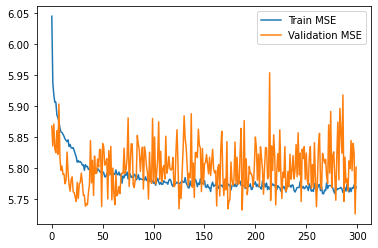

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(num_epochs), train_losses, label='Train MSE')
plt.plot(np.arange(num_epochs), valid_losses, label='Validation MSE')
plt.legend(loc='upper right')

In [ ]:
model.load_state_dict(torch.load(DATA_DIR + 'mlp-model_' + str(learning_rate) + '.pt'))

y_pred = model(torch.tensor(X_test).to(torch.float32).to(device))

In [ ]:
df_test['hindex'] = pd.Series(np.round_(y_pred.cpu().detach().numpy().squeeze(), decimals=3))


df_test.loc[:,["author","hindex"]].to_csv(DATA_DIR + 'inf554-2021/submission_11.csv', index=False)

## Node2Vec Embeddings

In [ ]:
f = open(DATA_DIR + 'coauthorship.emb', 'r')

print(f.readline())

217801 128



In [ ]:
embeddings = dict()

In [ ]:
for x in f:
  emb = x.split(' ')
  embeddings[int(emb[0])] = list(map(float, emb[1:]))

In [ ]:
emb_train = [embeddings[x] for x in df_train.author.values]
emb_train = np.array(emb_train)
y_train = df_train.hindex.values.reshape(-1, 1)

emb_test = [embeddings[x] for x in df_test.author.values]
emb_test = np.array(emb_test)

In [ ]:
mean_train = emb_train.mean(axis=0)
std_train = emb_train.std(axis=0)

emb_train = (emb_train - mean_train) / std_train
emb_test = (emb_test - mean_train) / std_train

In [ ]:
train_ratio = 0.9

n_train_examples = int(len(emb_train) * train_ratio)
n_valid_examples = len(emb_train) - n_train_examples

train_data = MyDataset(emb_train, y_train)

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [ ]:
batch_size = 64

train_loader = data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

valid_loader = data.DataLoader(valid_data, batch_size=batch_size)

test_loader = data.DataLoader(emb_test, batch_size=batch_size)

In [ ]:
input_dim = emb_train.shape[1]
output_dim = 1

model = MLP(input_dim, output_dim)

In [ ]:
learning_rate = 0.01

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
num_epochs = 300

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_errors = []
valid_errors = []

for epoch in range(num_epochs):
    
    train_loss, train_error = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_error = evaluate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_errors.append(train_error)
    valid_errors.append(valid_error)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), DATA_DIR + 'mlp-model_' + str(learning_rate) + '.pt')

    if epoch % 10 == 0:
      print(f'Epoch: {epoch:02}')
      print(f'\tTrain Loss: {train_loss:.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f} ')
      print()
      print(f'\tTrain MSE: {train_error:.3f}')
      print(f'\t Val. MSE: {valid_error:.3f} ')

Epoch: 00
	Train Loss: 6.624
	 Val. Loss: 6.340 

	Train MSE: 137.078
	 Val. MSE: 131.548 
Epoch: 10
	Train Loss: 6.214
	 Val. Loss: 6.058 

	Train MSE: 122.989
	 Val. MSE: 123.757 
Epoch: 20
	Train Loss: 6.131
	 Val. Loss: 6.182 

	Train MSE: 120.195
	 Val. MSE: 131.680 
Epoch: 30
	Train Loss: 6.107
	 Val. Loss: 6.205 

	Train MSE: 119.132
	 Val. MSE: 132.733 
Epoch: 40
	Train Loss: 6.101
	 Val. Loss: 6.082 

	Train MSE: 119.149
	 Val. MSE: 127.606 
Epoch: 50
	Train Loss: 6.077
	 Val. Loss: 6.196 

	Train MSE: 118.614
	 Val. MSE: 132.154 
Epoch: 60
	Train Loss: 6.069
	 Val. Loss: 6.049 

	Train MSE: 117.946
	 Val. MSE: 125.964 
Epoch: 70
	Train Loss: 6.060
	 Val. Loss: 6.074 

	Train MSE: 117.891
	 Val. MSE: 126.305 
Epoch: 80
	Train Loss: 6.068
	 Val. Loss: 6.073 

	Train MSE: 118.116
	 Val. MSE: 127.362 
Epoch: 90
	Train Loss: 6.052
	 Val. Loss: 6.106 

	Train MSE: 117.827
	 Val. MSE: 128.343 
Epoch: 100
	Train Loss: 6.063
	 Val. Loss: 6.135 

	Train MSE: 117.854
	 Val. MSE: 129.834

KeyboardInterrupt: ignored

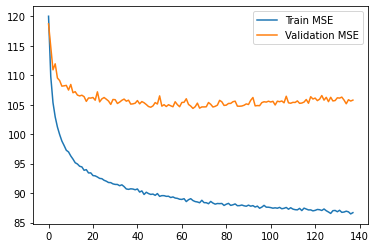

In [ ]:
plt.plot(np.arange(len(train_losses)), train_losses, label='Train MSE')
plt.plot(np.arange(len(valid_losses)), valid_losses, label='Validation MSE')
plt.legend(loc='upper right')

In [ ]:
model.load_state_dict(torch.load(DATA_DIR + 'mlp-model_' + str(learning_rate) + '.pt'))

y_pred = model(torch.tensor(emb_test).to(torch.float32).to(device))

In [ ]:
df_test['hindex'] = pd.Series(np.round_(y_pred.cpu().detach().numpy().squeeze(), decimals=3))


df_test.loc[:,["author","hindex"]].to_csv(DATA_DIR + 'inf554-2021/submission_12.csv', index=False)